In [24]:
from scipy import stats
import pandas as pd
import math
import os
# Calculate percentage MSE reduction for each dataset and horizon
def Calculate_percentage_MSE_reduction(data, dft_only=False, non_dft_only=False):
    results = {}
    non_comperable_models = ['nft']
    if dft_only: non_comperable_models = ['nft', 'tcn', 'patchtst', 'dlinear']
    if non_dft_only: non_comperable_models = ['nft', 'timesnet', 'nbeats', 'autoformer']
    
    for dataset, values in data.items():
        mse_reductions = {}
        for horizon_idx, horizon in enumerate(values['horizons']):
            # Extract MSE values for this horizon across all models
            mse_values = {model: mse[horizon_idx] for model, mse in values['models'].items()}
            # Calculate closest MSE (minimum) excluding NFT
            closest_mse = min(mse for model, mse in mse_values.items() if model not in non_comperable_models)
            # Calculate MSE reduction for NFT
            nft_mse = mse_values['nft']
            mse_reduction = (1 - (nft_mse / closest_mse)) * 100
            mse_reductions[horizon] = mse_reduction
        results[dataset] = mse_reductions

    return results

# Calculate the average percentage MSE reduction across horizons for each dataset
def Calculate_average_percentage_MSE(results, value_type='all'):
    average_results = {}
    for dataset, values in results.items():
        average_reduction = sum(values.values()) / len(values)
        average_results[dataset] = average_reduction
        
# Create DataFrame from the results
    new_data = pd.DataFrame({
        'dataset': average_results.keys(),
        'values': average_results.values(),
        'type': value_type
    })
    
    file_path  = '/home/../multiTS/NFT/results/precent_results.xlsx'
    # Check if the file already exists
    if os.path.exists(file_path):
        # Read the existing file
        existing_data = pd.read_excel(file_path, engine='openpyxl')
        # Concatenate the new data with the existing data
        combined_data = pd.concat([existing_data, new_data], ignore_index=True)
    else:
        combined_data = new_data
    
    # Save the combined data to Excel
    combined_data.to_excel(file_path, index=False, engine='openpyxl')
    
    print(average_results)
    return average_results

def Calculate_percentage_MSE_reduction_ablation(data_ablation):
    results_ablation_lstm = {}
    for dataset, values in data_ablation.items():
        mse_reductions = {}
        for horizon_idx, horizon in enumerate(values['horizons']):
            # Extract MSE values for this horizon across all models
            mse_values = {model: mse[horizon_idx] for model, mse in values['models'].items()}
            # Calculate closest MSE (minimum) excluding NFT
            closest_mse = min(mse for model, mse in mse_values.items() if model != 'nft' and model != 'fc nft')
            # Calculate MSE reduction for NFT
            nft_mse = mse_values['nft']
            mse_reduction = (1 - (nft_mse / closest_mse)) * 100
            mse_reductions[horizon] = mse_reduction
        results_ablation_lstm[dataset] = mse_reductions
        
    results_ablation_fc = {}
    for dataset, values in data_ablation.items():
        mse_reductions = {}
        for horizon_idx, horizon in enumerate(values['horizons']):
            # Extract MSE values for this horizon across all models
            mse_values = {model: mse[horizon_idx] for model, mse in values['models'].items()}
            # Calculate closest MSE (minimum) excluding NFT
            closest_mse = min(mse for model, mse in mse_values.items() if model != 'nft' and model != 'lstm nft')
            # Calculate MSE reduction for NFT
            nft_mse = mse_values['nft']
            mse_reduction = (1 - (nft_mse / closest_mse)) * 100
            mse_reductions[horizon] = mse_reduction
        results_ablation_fc[dataset] = mse_reductions
        
    
    return results_ablation_lstm, results_ablation_fc


def average_dict_values(data):
    if not data:
        return 0  # Return 0 for an empty dictionary
    
    total = 0
    count = 0
    
    for value in data.values():
        if not math.isnan(value):
            total += value
            count += 1
    if count == 0:
        return 0  # Avoid division by zero if all values are NaN
    return total / count

def Calulate_t_test(data):
    t_stat_dict = {}
    p_value_dict = {}

    for dataset, values in data.items():
        t_stat_dict[dataset] = {}
        p_value_dict[dataset] = {}
        nft_vals=values['models']['nft']
        for model, vals in values['models'].items():
            if model != 'nft':
                t_stat, p_value = stats.ttest_rel(nft_vals, vals)
                t_stat_dict[dataset][model] = t_stat
                p_value_dict[dataset][model] = p_value
    return t_stat_dict, p_value_dict

def calculate_average_t_p(t_stat_dict, p_value_dict):
    avg_t_stat = {}
    avg_p_value = {}

    # Calculate average for each dataset
    for dataset in t_stat_dict:
        avg_t_stat[dataset] = sum(t_stat_dict[dataset].values()) / len(t_stat_dict[dataset])
        avg_p_value[dataset] = sum(p_value_dict[dataset].values()) / len(p_value_dict[dataset])

    # Calculate overall average across all datasets
    total_t_stat = sum([sum(vals.values()) for vals in t_stat_dict.values()])
    total_t_count = sum([len(vals) for vals in t_stat_dict.values()])
    overall_avg_t_stat = average_dict_values(avg_t_stat)#total_t_stat / total_t_count

    total_p_value = sum([sum(vals.values()) for vals in p_value_dict.values()])
    total_p_count = sum([len(vals) for vals in p_value_dict.values()])
    overall_avg_p_value = average_dict_values(avg_p_value)#total_p_value / total_p_count

    return avg_t_stat, avg_p_value, overall_avg_t_stat, overall_avg_p_value


In [25]:
mse_data = {
'Traffic': {
    'horizons': [1, 16, 32, 48],
    'models': {
        'nft': [0.09, 0.18, 0.26, 0.4],
        'timesnet': [0.53, 0.58, 0.62, 0.62],
        'patchtst': [0.26, 0.58, 0.63, 0.66],
        'dlinear': [0.4, 0.63, 0.67, 0.72],
        'Autoformer': [0.5, 0.56, 0.67, 0.65],
        'tcn': [0.1, 0.46, 0.49, 0.51],
        'nbeats': [0.2, 0.51, 0.59, 0.71]
    }
},

    'Weather': {
        'horizons': [1, 7, 15, 30, 60, 90, 120, 180],
        'models': {
            'nft': [0.19, 0.24, 0.24, 0.25, 0.26, 0.27, 0.28, 0.27],
            'timesnet': [0.33, 0.35, 0.44, 0.36, 0.37, 0.37, 0.38, 0.37],
            'patchtst': [0.34, 0.36, 0.37, 0.38, 0.40, 0.42, 0.42, 0.43],
            'dlinear': [0.29, 0.32, 0.33, 0.35, 0.37, 0.40, 0.41, 0.40],
            'Autoformer': [0.37, 0.37, 0.37, 0.38, 0.42, 0.44, 0.46, 0.47],
            'tcn': [0.25, 0.29, 0.30, 0.32, 0.36, 0.33, 0.33, 0.35],
            'nbeats': [0.31, 0.33, 0.35, 0.38, 0.40, 0.42, 0.43, 0.44]
        }
    },

    'Electricity': {
        'horizons': [1, 16, 32],
        'models': {
            'nft': [0.04, 0.08, 0.13],
            'timesnet': [0.14, 0.16, 0.17],
            'patchtst': [0.09, 0.20, 0.17],
            'dlinear': [0.07, 0.16, 0.18],
            'Autoformer': [0.20, 0.40, 0.60],
            'tcn': [0.05, 0.32, 0.44],
            'nbeats': [0.06, 0.13, 0.18]
        }
    },

    'Exchange Rate all': {
    'horizons': [1, 16, 32, 48, 96, 192, 336, 720],
    'models': {
        'nft': [0.0001, 0.01, 0.02, 0.02, 0.02, 0.03, 0.04, 0.05],
        'timesnet': [0.05, 0.18, 0.15, 0.11, 0.107, 0.226, 0.367, 0.964],
        'patchtst': [0.01, 0.02, 0.03, 0.04, 0.09, 0.18, 0.4, 0.94],
        'dlinear': [0.01, 0.02, 0.03, 0.05, 0.088, 0.176, 0.313, 0.839],
        'Autoformer': [0.04, 0.04, 0.06, 0.09, 0.197, 0.300, 0.509, 1.447],
        'tcn': [0.2, 0.11, 0.04, 0.06, 0.09, 0.17, 0.24, 0.41],
        'nbeats': [0.01, 0.03, 0.05, 0.12, 0.17, 0.19, 0.21, 0.25]
    }
    },
    
    'ILI': {
        'horizons': [1, 12, 24, 36, 48, 60],
        'models': {
            'nft': [0.05, 0.18, 0.25, 0.31, 0.35, 0.42],
            'timesnet': [0.64, 1.01, 2.317, 1.972, 2.238, 2.027],
            'patchtst': [0.24, 1.25, 1.319, 1.579, 1.553, 1.470],
            'dlinear': [2.32, 2.83, 2.215, 1.963, 2.13, 2.368],
            'Autoformer': [0.84, 2.47, 3.483, 3.103, 2.669, 2.770],
            'tcn': [0.86, 0.98, 0.95, 0.94, 1.01, 1.03],
            'nbeats': [0.3, 1.33, 1.19, 1.44, 1.09, 1.48]
        }
    },
    'Air Quality': {
        'horizons': [1, 5, 10, 15, 20, 25, 30],
        'models': {
            'nft': [0.13, 0.21, 0.28, 0.31, 0.35, 0.38, 0.4],
            'timesnet': [0.74, 0.81, 0.85, 0.87, 0.85, 0.92, 0.96],
            'patchtst': [0.22, 0.58, 0.68, 0.72, 0.75, 0.78, 0.83],
            'dlinear': [0.39, 0.69, 0.78, 0.83, 0.87, 0.93, 1.01],
            'Autoformer': [0.72, 0.86, 0.97, 1.02, 0.98, 1.03, 0.99],
            'tcn': [0.21, 0.42, 0.53, 0.64, 0.69, 0.68, 0.69],
            'nbeats': [0.38, 0.64, 0.82, 0.86, 0.93, 1, 1.1]
        }
    },
    'ECG (600)': {
        'horizons': [1, 5, 10, 15, 20, 25, 30],
        'models': {
            'nft': [0.02, 0.08, 0.07, 0.1, 0.15, 0.15, 0.1],
            'timesnet': [0.02, 0.08, 0.08, 0.1, 0.15, 0.15, 0.17],
            'patchtst': [0.02 ,0.05 ,0.08 ,0.1 ,0.15 ,0.15 ,0.18],
            'dlinear': [0.02 ,0.06 ,0.08 ,0.11 ,0.14 ,0.16 ,0.19],
            'Autoformer': [0.8,0.49,0.38, 0.41 ,0.46 ,0.44 ,0.45],
            'tcn': [ 0.03 ,0.07 ,0.1 ,0.12 ,0.16 ,0.18 ,0.21],
            'nbeats': [ 0.07 ,0.07 ,0.11 ,0.15 ,0.18 ,0.22 ,0.28]
        }
    },
    'ECG': {
        'horizons': [1, 10, 25, 50, 100],
        'models': {
            'nft': [0.04, 0.08, 0.12, 0.14, 0.18],
            'timesnet': [0.31 ,0.49 ,0.625 ,1.16 ,1.09],
            'patchtst': [0.34 ,0.57 ,0.77 ,0.94 ,0.98],
            'dlinear': [0.35 ,0.46 ,0.58 ,0.66 ,0.69],
            'Autoformer': [1.62 ,1.13 ,1.5 ,1.15 ,1.26],
            'tcn': [0.16 ,0.42 ,0.56 ,0.70 ,0.81],
            'nbeats': [0.22 ,0.44 ,0.50 ,0.72 ,0.67]
        }
    },
    'EEG': {
        'horizons': [1, 10, 25],
        'models': {
            'nft': [0.03, 0.1, 0.16],
            'timesnet': [0.16, 0.35, 0.44],
            'patchtst': [0.15, 0.345, 0.42],
            'dlinear': [0.135, 0.365, 0.435],
            'Autoformer': [0.63, 0.545, 0.62],
            'tcn': [0.09, 0.32, 0.39],
            'nbeats': [0.37, 0.335, 0.336]
        }
    },
    'Chorales': {
        'horizons': [1, 2, 3, 4, 5],
        'models': {
            'nft': [0.15, 0.18, 0.20, 0.23, 0.22],
            'timesnet': [0.29, 0.3, 0.31, 0.31, 0.32],
            'patchtst': [0.34, 0.27, 0.29, 0.30, 0.31],
            'dlinear': [0.29, 0.29, 0.40, 0.37, 0.36],
            'Autoformer': [0.30, 0.25, 0.25, 0.26, 0.24],
            'tcn': [0.27, 0.63, 0.62, 0.37, 0.56],
            'nbeats': [0.35, 0.27, 0.27, 0.26, 0.29],
        }
    },

    'ETTh1': {
        'horizons': [1, 10, 24, 48, 96, 192, 336, 720],
        'models': {
            'nft': [0.07, 0.14, 0.18, 0.25, 0.39, 0.43, 0.44, 0.46],
            'timesnet': [0.15, 0.29, 0.33, 0.37, 0.38, 0.44, 0.49, 0.52],
            'patchtst': [0.1, 0.25, 0.29, 0.34, 0.37, 0.41, 0.42, 0.45],
            'dlinear': [0.12, 0.28, 0.31, 0.35, 0.37, 0.41, 0.44, 0.47],
            'Autoformer': [0.17, 0.4, 0.4, 0.427, 0.44, 0.46, 0.49, 0.52],
            'tcn': [0.14, 0.29, 0.43, 0.46, 0.46, 0.54, 0.53, 0.58],
            'nbeats': [0.11, 0.29, 0.33, 0.47, 0.71, 0.78, 0.79, 0.84]
        }
    },
    'ETTh1_long': {
        'horizons': [96, 192, 336, 720],
        'models': {
            'nft': [0.39, 0.43, 0.44, 0.46],
            'timesnet': [0.4, 0.44, 0.49, 0.52],
            'patchtst': [0.37, 0.41, 0.42, 0.45],
            'dlinear': [0.37, 0.41, 0.44, 0.47],
            'Autoformer': [0.43, 0.46, 0.49, 0.52],
            'tcn': [0.46, 0.54, 0.53, 0.58],
            'nbeats': [0.71, 0.78, 0.79, 0.84]
        }
    },
    'ETTh2': {
        'horizons': [1, 10, 24, 48, 96, 192, 336, 720],
        'models': {
            'nft': [0.06, 0.1, 0.13, 0.16, 0.19, 0.23, 0.26, 0.34],
            'timesnet': [0.1, 0.15, 0.2, 0.25, 0.34, 0.4, 0.45, 0.46],
            'patchtst': [0.06, 0.12, 0.17, 0.22, 0.274, 0.34, 0.33, 0.38],
            'dlinear': [0.11, 0.13, 0.18, 0.25, 0.289, 0.38, 0.45, 0.61],
            'Autoformer': [0.12, 0.21, 0.26, 0.32, 0.332, 0.43, 0.48, 0.45],
            'tcn': [0.06, 0.11, 0.15, 0.19, 0.24, 0.48, 0.54, 0.55],
            'nbeats': [0.14, 0.18, 0.24, 0.41, 1.65, 1.95, 1.75, 1.73]
        }
    },
    'ETTm1': {
        'horizons': [1, 10, 24, 48, 96, 192, 336, 720],
        'models': {
            'nft': [0.04, 0.07, 0.11, 0.14, 0.16, 0.24, 0.37, 0.43],
            'timesnet': [0.05, 0.13, 0.20, 0.29, 0.34, 0.37, 0.41, 0.48],
            'patchtst': [0.05, 0.12, 0.21, 0.28, 0.293, 0.33, 0.37, 0.42],
            'dlinear': [0.05, 0.14, 0.24, 0.31, 0.299, 0.34, 0.37, 0.43],
            'Autoformer': [0.09, 0.24, 0.4, 0.56, 0.51, 0.51, 0.51, 0.53],
            'tcn': [0.04, 0.09, 0.14, 0.19, 0.18, 0.47, 0.45, 0.54],
            'nbeats': [0.05, 0.13, 0.23, 0.3, 0.35, 0.5, 0.58, 0.79]
        }
    },
    'ETTm2': {
        'horizons': [1, 10, 24, 48, 96, 192, 336, 720],
        'models': {
            'nft': [0.03, 0.05, 0.07, 0.1, 0.13, 0.17, 0.22, 0.26],
            'timesnet': [0.04, 0.07, 0.11, 0.15, 0.16, 0.25, 0.32, 0.41],
            'patchtst': [0.03, 0.07, 0.1, 0.14, 0.166, 0.22, 0.27, 0.36],
            'dlinear': [0.03, 0.07, 0.11, 0.15, 0.167, 0.22, 0.28, 0.40],
            'Autoformer': [0.07, 0.1, 0.14, 0.165, 0.205, 0.28, 0.34, 0.41],
            'tcn': [0.03, 0.06, 0.09, 0.12, 0.16, 0.3, 0.34, 0.42],
            'nbeats': [0.04, 0.07, 0.14, 0.18, 0.26, 0.59, 0.81, 1.00]
        }
    }
    }

data_nbeats_mase = {
    'Weather': {
        'horizons': [1, 7, 15, 30, 60, 90, 120, 180],
        'models': {
            'nft': [79.68 , 90.39 , 91.27 , 92.2 , 95.39, 95.53 , 96.86 , 97.38],
            'nbeats': [92.77 ,96.86 ,99.92 ,97.02 ,99.48 ,99.89 ,100.69 , 102.27]
        }
    },
    'Electricity': {
        'horizons': [1, 16, 32],
        'models': {
            'nft': [34.06 , 52.14 , 63.29],
            'nbeats': [35.36 , 48.86 ,57.62]
        }
    },
    'Exchange Rate': {
        'horizons': [1, 16, 48],
        'models': {
            'nft': [7.25, 18.71, 30.5],
            'nbeats': [8.2, 17.9, 29.54],
        }
    },
    'ILI': {
        'horizons': [1, 12, 60],
        'models': {
            'nft': [44.86, 85.97, 92.21],
            'nbeats': [49.49, 86.61, 111.63],
        }
    },
    'Air Quality': {
        'horizons': [1, 5, 10, 15, 20, 25, 30],
        'models': {
            'nft': [58.38, 79.23 , 87.01 , 93.56 , 95.79 , 99.38 , 102.58],
             'nbeats': [75.37 ,83.85 ,100.55 ,102.78 ,103.91 ,109.81 ,111.67],
        }
    },
    'ECG (600)': {
        'horizons': [1, 5, 10, 15, 20, 25, 30],
        'models': {
            'nft': [24.07 ,43.86 ,45.26 ,53.87 ,59.81 ,60.03 , 68.3],
            'nbeats': [25.31 ,41.26 ,49.96 ,56.41 ,63.83 ,68.31 , 74.1],
        }
    },
    'ECG': {
        'horizons': [1, 10, 25, 50, 100],
        'models': {
            'nft': [40.47, 64.81, 74.70, 82.94, 88.75],
            'nbeats': [73.5,87.02,96.57,108.48,106.95],
        }
    },
    'EEG': {
        'horizons': [1, 10, 25],
        'models': {
            'nft': [45.83 , 62.90 , 72.23],
            'nbeats': [67.38,82.965,94],
        }
    },
    'Chorales': {
        'horizons': [1, 2, 3, 4, 5],
        'models': {
            'nft': [69.37 , 71.21 , 73.56 , 73.46 , 75.82],
            'nbeats': [70.36 ,71.43 ,71.55 ,72.68 ,76.4],
        }
    }
}

data_ablation_mase = {
    'Weather': {
        'horizons': [1, 7, 15, 30, 60, 90, 120, 180],
        'models': {
            'nft': [0.65, 0.75, 0.76, 0.79, 0.81, 0.82, 0.83, 0.85],
            'lstm nft': [0.73, 0.83, 0.87, 0.88, 0.90, 0.91, 0.91, 0.92],
            'fc nft': [0.86, 0.89, 0.90, 0.90, 0.92, 0.92, 0.91, 0.91]
        }
    },
    'Air Quality': {
        'horizons': [1, 5, 10, 15, 20, 25, 30],
        'models': {
            'nft': [0.15, 0.25, 0.30, 0.34, 0.35, 0.41, 0.39],
            'lstm nft': [0.25, 0.50, 0.52, 0.51, 0.61, 0.65, 0.62],
            'fc nft': [0.30, 0.45, 0.51, 0.56, 0.59, 0.60, 0.63]
        }
    },
    'ECG (600)': {
        'horizons': [1, 5, 10, 15, 20, 25, 30],
        'models': {
            'nft': [0.11, 0.24, 0.25, 0.32, 0.36, 0.37, 0.44],
            'lstm nft': [0.11, 0.20, 0.25, 0.30, 0.35, 0.38, 0.41],
            'fc nft': [0.16, 0.23, 0.27, 0.35, 0.36, 0.41, 0.44]
        }
    },
    'ECG': {
        'horizons': [1, 10, 25, 50, 100],
        'models': {
            'nft': [0.18, 0.34, 0.42, 0.49, 0.54],
            'lstm nft': [0.27, 0.59, 0.613, 0.6825, 0.715],
            'fc nft': [0.47, 0.557, 0.56, 0.6275, 0.6425]
        }
    },
    'EEG': {
        'horizons': [1, 10, 25],
        'models': {
            'nft': [0.14, 0.27, 0.34],
            'lstm nft': [0.185, 0.48, 0.63],
            'fc nft': [0.245, 0.49, 0.585]
        }
    },
    'Chorales': {
        'horizons': [1, 2, 3, 4, 5],
        'models': {
            'nft': [0.27, 0.24, 0.25, 0.27, 0.28],
            'lstm nft': [0.21, 0.22, 0.23, 0.23, 0.24],
            'fc nft': [0.32, 0.27, 0.26, 0.29, 0.32]
        }
    }
}

data_ablation_smape = {
    'Weather': {
        'horizons': [1, 7, 15, 30, 60, 90, 120, 180],
        'models': {
            'nft': [79.68, 90.39, 91.27, 92.27, 95.39, 95.53, 96.86, 97.38],
            'lstm nft': [84.94, 92.57, 93.35, 94.36, 95.72, 96.18, 97.90, 98.64],
            'fc nft': [91.08, 93.95, 95.89, 94.80, 97.08, 98.38, 98.54, 98.12]
        }
    },
    'Air Quality': {
        'horizons': [1, 5, 10, 15, 20, 25, 30],
        'models': {
            'nft': [58.38, 79.23, 87.01, 93.56, 95.79, 99.38, 102.58],
            'lstm nft': [76.03, 113.43, 117.59, 113.79, 126.13, 127.83, 124.97],
            'fc nft': [86.05, 104.42, 113.86, 119.42, 124.11, 125.50, 126.63]
        }
    },
    'ECG (600)': {
        'horizons': [1, 5, 10, 15, 20, 25, 30],
        'models': {
            'nft': [24.07, 43.86, 45.26, 53.87, 59.81, 60.03, 68.39],
            'lstm nft': [25.86, 39.42, 46.68, 52.26, 59.88, 63.40, 66.84],
            'fc nft': [35.07, 43.96, 49.07, 60.21, 59.71, 65.59, 69.99]
        }
    },
    'ECG': {
        'horizons': [1, 10, 25, 50, 100],
        'models': {
            'nft': [40.47, 64.81, 74.70, 82.94, 88.75],
            'lstm nft': [52.91, 87.48, 94.17, 98.95, 103.40],
            'fc nft': [79.23, 86.99, 90.93, 95.28, 98.03]
        }
    },
    'EEG': {
        'horizons': [1, 10, 25],
        'models': {
            'nft': [45.83, 62.90, 72.23],
            'lstm nft': [49.80, 88.16, 104.18],
            'fc nft': [59.50, 89.85, 104.16]
        }
    },
    'Chorales': {
        'horizons': [1, 2, 3, 4, 5],
        'models': {
            'nft': [69.37, 71.21, 73.56, 73.46, 75.82],
            'lstm nft': [95.14, 90.37, 86.56, 88.99, 91.87],
            'fc nft': [86.47, 76.74, 75.65, 79.05, 84.91]
        }
    }
}

data_ablation_mse = {
    'Weather': {
        'horizons': [1, 7, 15, 30, 60, 90, 120, 180],
        'models': {
            'nft': [0.19, 0.24, 0.24, 0.25, 0.26, 0.27, 0.28, 0.27],
            'lstm nft': [0.29, 0.33, 0.36, 0.37, 0.39, 0.41, 0.42, 0.44],
            'fc nft': [0.41, 0.39, 0.40, 0.39, 0.40, 0.41, 0.42, 0.41]
        }
    },
    'Air Quality': {
        'horizons': [1, 5, 10, 15, 20, 25, 30],
        'models': {
            'nft': [0.13, 0.21, 0.28, 0.31, 0.35, 0.38, 0.40],
            'lstm nft': [0.38, 1.21, 1.29, 1.25, 1.76, 2.02, 1.78],
            'fc nft': [0.49, 1.04, 1.27, 1.51, 1.62, 1.72, 1.88]
        }
    },
    'ECG (600)': {
        'horizons': [1, 5, 10, 15, 20, 25, 30],
        'models': {
            'nft': [0.02, 0.08, 0.07, 0.10, 0.15, 0.15, 0.10],
            'lstm nft': [0.07, 0.07, 0.10, 0.14, 0.15, 0.18, 0.21],
            'fc nft': [0.08, 0.08, 0.12, 0.16, 0.19, 0.22, 0.24]
        }
    },
    'ECG': {
        'horizons': [1, 10, 25, 50, 100],
        'models': {
            'nft': [0.04, 0.08, 0.12, 0.14, 0.18],
            'lstm nft': [0.085, 0.3675, 0.4375, 0.5225, 0.5825],
            'fc nft': [0.225, 0.3375, 0.4025, 0.475, 0.5175]
        }
    },
    'EEG': {
        'horizons': [1, 10, 25],
        'models': {
            'nft': [0.03, 0.10, 0.16],
            'lstm nft': [0.10, 0.445, 0.655],
            'fc nft': [0.125, 0.425, 0.545]
        }
    },
    'Chorales': {
        'horizons': [1, 2, 3, 4, 5],
        'models': {
            'nft': [0.15, 0.18, 0.20, 0.23, 0.22],
            'lstm nft': [0.36, 0.30, 0.26, 0.245, 0.23],
            'fc nft': [0.35, 0.29, 0.28, 0.29, 0.28]
        }
    }
}


In [ ]:
results = Calculate_percentage_MSE_reduction(mse_data)
Calculate_average_percentage_MSE(results)

In [ ]:
results = Calculate_percentage_MSE_reduction(mse_data, non_dft_only=True)
Calculate_average_percentage_MSE(results, 'non dft')

In [ ]:
results = Calculate_percentage_MSE_reduction(mse_data, dft_only=True)
Calculate_average_percentage_MSE(results, 'dft')

In [ ]:
import pandas as pd

datasets = []
horizons_list = []
predictive_ranges = []
nft_mses = []
closest_baseline_mses = []
improvements = []

for dataset in mse_data:
    horizons = mse_data[dataset]['horizons']
    nft_mse = mse_data[dataset]['models']['nft']
    
    # Get the MSE values of all baseline models excluding NFT
    baseline_models = {model: mse for model, mse in mse_data[dataset]['models'].items() if model != 'nft'}
    
    for i, mse in enumerate(nft_mse):
        # Calculate the percentage of the predictive range
        predictive_range_percentage = horizons[i] / max(horizons) * 100
        
        # Find the closest baseline MSE for the current NFT MSE
        closest_baseline_mse = min([mse_list[i] for mse_list in baseline_models.values()], key=lambda x: abs(x - mse))
        
        # Calculate the improvement percentage over the closest baseline MSE
        improvement_percentage = (closest_baseline_mse - mse) / closest_baseline_mse * 100
        
        datasets.append(dataset)
        horizons_list.append(horizons[i])
        predictive_ranges.append(predictive_range_percentage)
        nft_mses.append(mse)
        closest_baseline_mses.append(closest_baseline_mse)
        improvements.append(improvement_percentage)

# Create a dataframe for the results
df_results = pd.DataFrame({
    'dataset': datasets,
    'horizon': horizons_list,
    'predictive_range_percentage': predictive_ranges,
    'nft_mse': nft_mses,
    'closest_baseline_mse': closest_baseline_mses,
    'improvement_percentage': improvements
})

# Calculate the correlation
correlation = df_results.groupby('dataset').apply(lambda x: x['predictive_range_percentage'].corr(x['improvement_percentage']))
print("Correlation between the percentage of improvement and the percentage of the predictive range")
print(correlation)

# Save the detailed results to an Excel file
df_results.to_excel("precentage_results.xlsx", index=False)
print("Results saved to results.xlsx")


In [76]:
ETT_mse_data = {
    'ETTh1': {
        'horizons': [1, 10, 24, 48, 96, 192, 336, 720],
        'models': {
            'nft': [0.07, 0.14, 0.18, 0.25, 0.39, 0.43, 0.44, 0.46],
            'timesnet': [0.15, 0.29, 0.33, 0.37, 0.4, 0.44, 0.49, 0.52],
            'patchtst': [0.1, 0.25, 0.29, 0.34, 0.37, 0.41, 0.42, 0.45],
            'dlinear': [0.12, 0.28, 0.31, 0.35, 0.37, 0.41, 0.44, 0.47],
            'Autoformer': [0.17, 0.4, 0.4, 0.427, 0.43, 0.46, 0.49, 0.52],
            'tcn': [0.14, 0.29, 0.43, 0.46, 0.46, 0.54, 0.53, 0.58],
            'nbeats': [0.11, 0.29, 0.33, 0.47, 0.71, 0.78, 0.79, 0.84]
        }
    },
    'ETTh2': {
        'horizons': [1, 10, 24, 48, 96, 192, 336, 720],
        'models': {
            'nft': [0.06, 0.1, 0.13, 0.16, 0.19, 0.23, 0.26, 0.34],
            'timesnet': [0.1, 0.15, 0.2, 0.25, 0.25, 0.4, 0.45, 0.46],
            'patchtst': [0.06, 0.12, 0.17, 0.22, 0.274, 0.34, 0.33, 0.38],
            'dlinear': [0.11, 0.13, 0.18, 0.25, 0.289, 0.38, 0.45, 0.61],
            'Autoformer': [0.12, 0.21, 0.26, 0.32, 0.332, 0.43, 0.48, 0.45],
            'tcn': [0.06, 0.11, 0.15, 0.19, 0.24, 0.48, 0.54, 0.55],
            'nbeats': [0.14, 0.18, 0.24, 0.41, 0.5, 1.2, 1.35, 1.73]
        }
    },
    'ETTm1': {
        'horizons': [1, 10, 24, 48, 96, 192, 336, 720],
        'models': {
            'nft': [0.04, 0.07, 0.11, 0.14, 0.16, 0.24, 0.37, 0.43],
            'timesnet': [0.05, 0.13, 0.17, 0.24, 0.26, 0.37, 0.41, 0.48],
            'patchtst': [0.05, 0.12, 0.21, 0.28, 0.293, 0.33, 0.37, 0.42],
            'dlinear': [0.05, 0.14, 0.24, 0.31, 0.299, 0.34, 0.37, 0.43],
            'Autoformer': [0.09, 0.24, 0.4, 0.56, 0.51, 0.51, 0.51, 0.53],
            'tcn': [0.04, 0.09, 0.14, 0.19, 0.23, 0.47, 0.45, 0.54],
            'nbeats': [0.05, 0.13, 0.23, 0.3, 0.35, 0.5, 0.58, 0.79]
        }
    },
    'ETTm2': {
        'horizons': [1, 10, 24, 48, 96, 192, 336, 720],
        'models': {
            'nft': [0.03, 0.05, 0.07, 0.1, 0.13, 0.17, 0.22, 0.26],
            'timesnet': [0.04, 0.07, 0.11, 0.14, 0.16, 0.25, 0.32, 0.41],
            'patchtst': [0.03, 0.07, 0.1, 0.14, 0.166, 0.22, 0.27, 0.36],
            'dlinear': [0.03, 0.07, 0.11, 0.15, 0.167, 0.22, 0.28, 0.40],
            'Autoformer': [0.07, 0.1, 0.14, 0.165, 0.205, 0.28, 0.34, 0.41],
            'tcn': [0.03, 0.06, 0.09, 0.12, 0.16, 0.3, 0.34, 0.42],
            'nbeats': [0.04, 0.07, 0.14, 0.18, 0.26, 0.59, 0.81, 1.00]
        }
    }
}


In [ ]:
results = Calculate_percentage_MSE_reduction(ETT_mse_data)
Calculate_average_percentage_MSE(results)

In [74]:
ETT_mse_data = {
    'ETTh1': {
        'horizons': [1, 10, 24, 48, 96, 192, 336, 720],
        'models': {
            'nft': [0.07, 0.14, 0.18, 0.25, 0.39, 0.43, 0.44, 0.46],
            'timesnet': [0.15, 0.29, 0.33, 0.37, 0.38, 0.44, 0.49, 0.52],
            'patchtst': [0.1, 0.25, 0.29, 0.34, 0.37, 0.41, 0.42, 0.45],
            'dlinear': [0.12, 0.28, 0.31, 0.35, 0.37, 0.41, 0.44, 0.47],
            'Autoformer': [0.17, 0.4, 0.4, 0.427, 0.44, 0.46, 0.49, 0.52],
            'tcn': [0.14, 0.29, 0.43, 0.46, 0.46, 0.54, 0.53, 0.58],
            'nbeats': [0.11, 0.29, 0.33, 0.47, 0.71, 0.78, 0.79, 0.84]
        }
    },
    'ETTh1_long': {
        'horizons': [96, 192, 336, 720],
        'models': {
            'nft': [0.39, 0.43, 0.44, 0.46],
            'timesnet': [0.4, 0.44, 0.49, 0.52],
            'patchtst': [0.37, 0.41, 0.42, 0.45],
            'dlinear': [0.37, 0.41, 0.44, 0.47],
            'Autoformer': [0.43, 0.46, 0.49, 0.52],
            'tcn': [0.46, 0.54, 0.53, 0.58],
            'nbeats': [0.71, 0.78, 0.79, 0.84]
        }
    },
    'ETTh2': {
        'horizons': [1, 10, 24, 48, 96, 192, 336, 720],
        'models': {
            'nft': [0.06, 0.1, 0.13, 0.16, 0.19, 0.23, 0.26, 0.34],
            'timesnet': [0.1, 0.15, 0.2, 0.25, 0.34, 0.4, 0.45, 0.46],
            'patchtst': [0.06, 0.12, 0.17, 0.22, 0.274, 0.34, 0.33, 0.38],
            'dlinear': [0.11, 0.13, 0.18, 0.25, 0.289, 0.38, 0.45, 0.61],
            'Autoformer': [0.12, 0.21, 0.26, 0.32, 0.332, 0.43, 0.48, 0.45],
            'tcn': [0.06, 0.11, 0.15, 0.19, 0.24, 0.48, 0.54, 0.55],
            'nbeats': [0.14, 0.18, 0.24, 0.41, 1.65, 1.95, 1.75, 1.73]
        }
    },
    'ETTm1': {
        'horizons': [1, 10, 24, 48, 96, 192, 336, 720],
        'models': {
            'nft': [0.04, 0.07, 0.11, 0.14, 0.16, 0.24, 0.37, 0.43],
            'timesnet': [0.05, 0.13, 0.20, 0.29, 0.34, 0.37, 0.41, 0.48],
            'patchtst': [0.05, 0.12, 0.21, 0.28, 0.293, 0.33, 0.37, 0.42],
            'dlinear': [0.05, 0.14, 0.24, 0.31, 0.299, 0.34, 0.37, 0.43],
            'Autoformer': [0.09, 0.24, 0.4, 0.56, 0.51, 0.51, 0.51, 0.53],
            'tcn': [0.04, 0.09, 0.14, 0.19, 0.18, 0.47, 0.45, 0.54],
            'nbeats': [0.05, 0.13, 0.23, 0.3, 0.35, 0.5, 0.58, 0.79]
        }
    },
    'ETTm2': {
        'horizons': [1, 10, 24, 48, 96, 192, 336, 720],
        'models': {
            'nft': [0.03, 0.05, 0.07, 0.1, 0.13, 0.17, 0.22, 0.26],
            'timesnet': [0.04, 0.07, 0.11, 0.15, 0.16, 0.25, 0.32, 0.41],
            'patchtst': [0.03, 0.07, 0.1, 0.14, 0.166, 0.22, 0.27, 0.36],
            'dlinear': [0.03, 0.07, 0.11, 0.15, 0.167, 0.22, 0.28, 0.40],
            'Autoformer': [0.07, 0.1, 0.14, 0.165, 0.205, 0.28, 0.34, 0.41],
            'tcn': [0.03, 0.06, 0.09, 0.12, 0.16, 0.3, 0.34, 0.42],
            'nbeats': [0.04, 0.07, 0.14, 0.18, 0.26, 0.59, 0.81, 1.00]
        }
    }
}


In [60]:
mse_data_long = {
'Traffic long': {
    'horizons': [32, 48],
    'models': {
        'nft': [0.26, 0.4],
        'timesnet': [0.62, 0.62],
        'patchtst': [0.63, 0.66],
        'dlinear': [0.67, 0.72],
        'Autoformer': [0.67, 0.65],
        'tcn': [0.49, 0.51]
    }
},
    'Weather long': {
        'horizons': [60, 90, 120, 180],
        'models': {
            'nft': [0.26, 0.27, 0.28, 0.27],
            'timesnet': [0.37, 0.37, 0.38, 0.37],
            'patchtst': [0.40, 0.42, 0.42, 0.43],
            'dlinear': [0.37, 0.40, 0.41, 0.40],
            'Autoformer': [0.42, 0.44, 0.46, 0.47],
            'tcn': [0.36, 0.33, 0.33, 0.35]
        }
    },

    'Electricity long': {
        'horizons': [32],
        'models': {
            'nft': [0.13],
            'timesnet': [0.17],
            'patchtst': [0.17],
            'dlinear': [0.18],
            'Autoformer': [0.60],
            'tcn': [0.44]
        }
    },
    'Exchange Rate long': {
    'horizons': [96, 192, 336, 720],
    'models': {
        'nft': [0.02, 0.03, 0.04, 0.05],
        'timesnet': [0.107, 0.226, 0.367, 0.964],
        'patchtst': [0.09, 0.18, 0.4, 0.94],
        'dlinear': [0.088, 0.176, 0.313, 0.839],
        'Autoformer': [0.197, 0.300, 0.509, 1.447],
        'tcn': [0.09, 0.17, 0.24, 0.41]
    }
    },
    'ILI long': {
        'horizons': [36, 48, 60],
        'models': {
            'nft': [0.31, 0.35, 0.42],
            'timesnet': [1.972, 2.238, 2.027],
            'patchtst': [1.579, 1.553, 1.470],
            'dlinear': [1.963, 2.13, 2.368],
            'Autoformer': [3.103, 2.669, 2.770],
            'tcn': [0.94, 1.01, 1.03]
        }
    },
    'Air Quality long': {
        'horizons': [20, 25, 30],
        'models': {
            'nft': [0.35, 0.38, 0.4],
            'timesnet': [0.85, 0.92, 0.96],
            'patchtst': [0.75, 0.78, 0.83],
            'dlinear': [0.87, 0.93, 1.01],
            'Autoformer': [0.98, 1.03, 0.99],
            'tcn': [0.69, 0.68, 0.69]
        }
    },
   'ECG (600) long': {
        'horizons': [20, 25, 30],
        'models': {
            'nft': [0.15, 0.15, 0.1],
            'timesnet': [0.15,0.15,0.1],
            'patchtst': [0.15 ,0.15 ,0.18],
            'dlinear': [0.14 ,0.16 ,0.19],
            'Autoformer': [0.46 ,0.44 ,0.45],
            'tcn': [0.16 ,0.18 ,0.21]
        }
    },
   'ECG long': {
        'horizons': [50, 100],
        'models': {
            'nft': [0.14, 0.18],
            'timesnet': [1.16 ,1.09],
            'patchtst': [0.94 ,0.98],
            'dlinear': [0.66 ,0.69],
            'Autoformer': [1.15 ,1.26],
            'tcn': [0.70 ,0.81]
        }
    },
    'EEG long': {
        'horizons': [25],
        'models': {
            'nft': [0.16],
            'timesnet': [0.44],
            'patchtst': [0.42],
            'dlinear': [0.435],
            'Autoformer': [0.62],
            'tcn': [0.39]
        }
    },
    'Chorales long': {
        'horizons': [4, 5],
        'models': {
            'nft': [0.23, 0.22],
            'timesnet': [0.31, 0.32],
            'patchtst': [0.30, 0.31],
            'dlinear': [0.37, 0.36],
            'Autoformer': [0.26, 0.24],
            'tcn': [0.37, 0.56]
        }
    },
    'ETTh1 long': {
        'horizons': [48, 96],
        'models': {
            'nft': [0.25, 0.39],
            'timesnet': [0.37, 0.4],
            'patchtst': [0.34, 0.37],
            'dlinear': [0.35, 0.37],
            'Autoformer': [0.427, 0.43],
            'tcn': [0.46, 0.46],
            'nbeats': [0.47, 0.71]
        }
    },
    'ETTh2 long': {
        'horizons': [48, 96],
        'models': {
            'nft': [0.16, 0.19],
            'timesnet': [0.25, 0.25],
            'patchtst': [0.22, 0.274],
            'dlinear': [0.25, 0.289],
            'Autoformer': [0.32, 0.332],
            'tcn': [0.19, 0.24],
            'nbeats': [0.41, 0.5]
        }
    },
   'ETTm1 long': {
        'horizons': [48, 96],
        'models': {
            'nft': [0.14, 0.16],
            'timesnet': [0.24, 0.26],
            'patchtst': [0.28, 0.293],
            'dlinear': [0.31, 0.299],
            'Autoformer': [0.56, 0.51],
            'tcn': [0.19, 0.23],
            'nbeats': [0.3, 0.35]
        }
    },
    'ETTm2 long': {
        'horizons': [48, 96],
        'models': {
            'nft': [0.1, 0.13],
            'timesnet': [0.14, 0.16],
            'patchtst': [0.14, 0.166],
            'dlinear': [0.15, 0.167],
            'Autoformer': [0.165, 0.205],
            'tcn': [0.12, 0.16],
            'nbeats': [0.18, 0.26]
        }
    }
    }

In [61]:
mse_data_sort = {
'Traffic sort': {
    'horizons': [1, 16],
    'models': {
        'nft': [0.09, 0.18],
        'timesnet': [0.53, 0.58],
        'patchtst': [0.26, 0.58],
        'dlinear': [0.4, 0.63],
        'Autoformer': [0.5, 0.56],
        'tcn': [0.1, 0.46]
    }
},
'Weather sort': {
        'horizons': [1, 7, 15, 30],
        'models': {
            'nft': [0.19, 0.24, 0.24, 0.25],
            'timesnet': [0.33, 0.35, 0.44, 0.36],
            'patchtst': [0.34, 0.36, 0.37, 0.38],
            'dlinear': [0.29, 0.32, 0.33, 0.35],
            'Autoformer': [0.37, 0.37, 0.37, 0.38],
            'tcn': [0.25, 0.29, 0.30, 0.32]
        }
    },

'Electricity sort': {
        'horizons': [1, 16],
        'models': {
            'nft': [0.04, 0.08],
            'timesnet': [0.14, 0.16],
            'patchtst': [0.09, 0.20],
            'dlinear': [0.07, 0.16],
            'Autoformer': [0.20, 0.40],
            'tcn': [0.05, 0.32]
        }
    },
'Exchange Rate sort': {
        'horizons': [1, 16, 32, 48],
        'models': {
            'nft': [0.0001, 0.01, 0.02, 0.02],
            'timesnet': [0.05, 0.18, 0.15, 0.11],
            'patchtst': [0.01, 0.02, 0.03, 0.04],
            'dlinear': [0.01, 0.02, 0.03, 0.05],
            'Autoformer': [0.04, 0.04, 0.06, 0.09],
            'tcn': [0.2, 0.11, 0.04, 0.06]
        }
    },
'ILI sort': {
        'horizons': [1, 12, 24],
        'models': {
            'nft': [0.05, 0.18, 0.25],
            'timesnet': [0.64, 1.01, 2.317],
            'patchtst': [0.24, 1.25, 1.319],
            'dlinear': [2.32, 2.83, 2.215],
            'Autoformer': [0.84, 2.47, 3.483],
            'tcn': [0.86, 0.98, 0.95]
        }
    },
'Air Quality sort': {
        'horizons': [1, 5, 10, 15],
        'models': {
            'nft': [0.13, 0.21, 0.28, 0.31],
            'timesnet': [0.74, 0.81, 0.85, 0.87],
            'patchtst': [0.22, 0.58, 0.68, 0.72],
            'dlinear': [0.39, 0.69, 0.78, 0.83],
            'Autoformer': [0.72, 0.86, 0.97, 1.02],
            'tcn': [0.21, 0.42, 0.53, 0.64]
        }
    },
'ECG (600) sort': {
        'horizons': [1, 5, 10, 15],
        'models': {
            'nft': [0.02, 0.08, 0.07, 0.1],
            'timesnet': [0.02,0.08,0.07,0.1],
            'patchtst': [0.02 ,0.05 ,0.08 ,0.1],
            'dlinear': [0.02 ,0.06 ,0.08 ,0.11],
            'Autoformer': [0.8,0.49,0.38, 0.41],
            'tcn': [ 0.03 ,0.07 ,0.1 ,0.12]
        }
    },
'ECG sort': {
        'horizons': [1, 10, 25],
        'models': {
            'nft': [0.04, 0.08, 0.12],
            'timesnet': [0.31 ,0.49 ,0.625],
            'patchtst': [0.34 ,0.57 ,0.77],
            'dlinear': [0.35 ,0.46 ,0.58],
            'Autoformer': [1.62 ,1.13 ,1.5],
            'tcn': [0.16 ,0.42 ,0.56]
        }
    },
'EEG sort': {
        'horizons': [1, 10],
        'models': {
            'nft': [0.03, 0.1],
            'timesnet': [0.16, 0.35],
            'patchtst': [0.15, 0.345],
            'dlinear': [0.135, 0.365],
            'Autoformer': [0.63, 0.545],
            'tcn': [0.09, 0.32],
            'tcn': [0.09, 0.32],
        }
    },
'Chorales sort': {
        'horizons': [1, 2, 3],
        'models': {
            'nft': [0.15, 0.18, 0.20],
            'timesnet': [0.29, 0.3, 0.31],
            'patchtst': [0.34, 0.27, 0.29],
            'dlinear': [0.29, 0.29, 0.40],
            'Autoformer': [0.30, 0.25, 0.25],
            'tcn': [0.27, 0.63, 0.62]
        }
    },
 'ETTh1 sort': {
        'horizons': [1, 10, 24],
        'models': {
            'nft': [0.07, 0.14, 0.18],
            'timesnet': [0.15, 0.29, 0.33],
            'patchtst': [0.1, 0.25, 0.29],
            'dlinear': [0.12, 0.28, 0.31],
            'Autoformer': [0.17, 0.4, 0.4],
            'tcn': [0.14, 0.29, 0.43],
            'nbeats': [0.11, 0.29, 0.33]
        }
    },
'ETTh2 short': {
        'horizons': [1, 10, 24],
        'models': {
            'nft': [0.06, 0.1, 0.13],
            'timesnet': [0.1, 0.15, 0.2],
            'patchtst': [0.06, 0.12, 0.17],
            'dlinear': [0.11, 0.13, 0.18],
            'Autoformer': [0.12, 0.21, 0.26],
            'tcn': [0.06, 0.11, 0.15],
            'nbeats': [0.14, 0.18, 0.24]
        }
    },
'ETTm1 short': {
        'horizons': [1, 10, 24],
        'models': {
            'nft': [0.04, 0.07, 0.11],
            'timesnet': [0.05, 0.13, 0.17],
            'patchtst': [0.05, 0.12, 0.21],
            'dlinear': [0.05, 0.14, 0.24],
            'Autoformer': [0.09, 0.24, 0.4],
            'tcn': [0.04, 0.09, 0.14],
            'nbeats': [0.05, 0.13, 0.23]
        }
    },
'ETTm2 short': {
        'horizons': [1, 10, 24],
        'models': {
            'nft': [0.03, 0.05, 0.07],
            'timesnet': [0.04, 0.07, 0.11],
            'patchtst': [0.03, 0.07, 0.1],
            'dlinear': [0.03, 0.07, 0.11],
            'Autoformer': [0.07, 0.1, 0.14],
            'tcn': [0.03, 0.06, 0.09],
            'nbeats': [0.04, 0.07, 0.14]
        }
    },
    }


In [ ]:
results = Calculate_percentage_MSE_reduction(ETT_mse_data)
Calculate_average_percentage_MSE(results)

In [ ]:
results = Calculate_percentage_MSE_reduction(mse_data_long)
Calculate_average_percentage_MSE(results)

In [ ]:

# Example usage
t_stat_dict, p_value_dict = Calulate_t_test(mse_data)  # Assume 'data' is your dataset dictionary
avg_t_stat, avg_p_value, overall_avg_t_stat, overall_avg_p_value = calculate_average_t_p(t_stat_dict, p_value_dict)
print(avg_t_stat)
print(avg_p_value)
print(overall_avg_t_stat)
print(overall_avg_p_value)


In [ ]:

results_ablation_lstm, results_ablation_fc = Calculate_percentage_MSE_reduction_ablation(data_ablation_mse)
average_mse_lstm_results = Calculate_average_percentage_MSE(results_ablation_lstm)
average_mse_fc_results = Calculate_average_percentage_MSE(results_ablation_fc)
average_dict_values(average_mse_lstm_results)
average_dict_values(average_mse_fc_results)


In [1]:
from scipy.stats import ttest_rel

# Input data
data = {
    "ECL": {
        1: [0.051, 0.054],
        16: [0.080, 0.097],
        32: [0.141, 0.147],
    },
    "Exchange": {
        96: [0.060, 0.081],
        192: [0.164, 0.171],
        336: [0.422, 0.313],
        720: [0.670, 0.611],
    },
    "Traffic": {
        1: [0.200, 0.213],
        16: [0.320, 0.328],
        32: [0.390, 0.408],
        48: [0.400, 0.416],
    },
    "ETTm1": {
        48: [0.270, 0.280],
        96: [0.241, 0.287],
        192: [0.320, 0.327],
        336: [0.400, 0.355],
    },
    "Weather": {
        15: [0.364, 0.372],
        30: [0.383, 0.395],
        60: [0.383, 0.392],
        90: [0.481, 0.481],
    },
    "ECG": {
        # 1: [0.080, 0.085],
        10: [0.172, 0.223],
        25: [0.258, 0.338],
        50: [0.400, 0.410],
        100: [0.393, 0.460],
    },
    "EEG": {
        1: [0.075, 0.084],
        10: [0.159, 0.163],
        25: [0.238, 0.243],
    },
    "Chorales": {
        1: [0.223, 0.248],
        2: [0.242, 0.251], 
        3: [0.259, 0.250],
        4: [0.260, 0.265],
    },
    "Air_Quality": {
        5: [0.513, 0.580],
        10: [0.641, 0.655],
        15: [0.717, 0.72],
        25: [0.779, 0.78],
        },
    }

# Conduct t-tests and calculate improvement percentages
results = {}

for dataset, entries in data.items():
    improvements = []
    values1 = []
    values2 = []

    for key, values in entries.items():
        val1, val2 = values
        improvement = ((val2 - val1) / val1) * 100
        improvements.append(improvement)
        values1.append(val1)
        values2.append(val2)

    # Average improvement
    average_improvement = sum(improvements) / len(improvements)
    results[dataset] = average_improvement


# Print the results
for dataset, avg_improvement in results.items():
    print(f"{dataset}: Average Improvement = {avg_improvement:.2f}%")




ECL: Average Improvement = 10.46%
Exchange: Average Improvement = 1.16%
Traffic: Average Improvement = 4.40%
ETTm1: Average Improvement = 3.43%
Weather: Average Improvement = 1.92%
ECG: Average Improvement = 20.05%
EEG: Average Improvement = 5.54%
Chorales: Average Improvement = 3.34%
Air_Quality: Average Improvement = 3.95%


In [2]:
from scipy.stats import ttest_rel

# Input data
mae_data = {
    "ECL": {
        1: [0.146, 0.129],
        16: [0.216, 0.190],
        32: [0.136, 0.128],
    },
    "Exchange": {
        96: [0.173, 0.200],
        192: [0.290, 0.293],
        336: [0.405, 0.397],
        720: [0.601, 0.603],
    },
    "Traffic": {
        1: [0.190, 0.193],
        16: [0.270, 0.220],
        32: [0.330, 0.306],
        48: [0.410, 0.242],
    },
    "ETTm1": {
        48: [0.310, 0.340],
        96: [0.307, 0.310],
        192: [0.378, 0.330],
        336: [0.439, 0.370],
    },
    "Weather": {
        96: [0.491, 0.493],
        192: [0.510, 0.540],
        336: [0.498, 0.516],
        720: [0.536, 0.529],
    },
    "ECG": {
        # 1: [0.080, 0.085],
        10: [0.305, 0.323],
        25: [0.375, 0.406],
        50: [0.564, 0.417],
        100: [0.481, 0.507],
    },
    "EEG": {
        1: [0.101, 0.133],
        10: [0.194, 0.215],
        25: [0.290, 0.430],
    },
    "Chorales": {
        1: [0.199, 0.176],
        2: [0.204, 0.189], 
        3: [0.201, 0.220],
        4: [0.226, 0.229],
    },
    "Air_Quality": {
        5: [0.513, 0.580],
        10: [0.641, 0.655],
        15: [0.717, 0.72],
        25: [0.779, 0.78],
        },
    }

# Conduct t-tests and calculate improvement percentages
results = {}

for dataset, entries in mae_data.items():
    improvements = []
    values1 = []
    values2 = []

    for key, values in entries.items():
        val1, val2 = values
        improvement = ((val2 - val1) / val1) * 100
        improvements.append(improvement)
        values1.append(val1)
        values2.append(val2)

    # Average improvement
    average_improvement = sum(improvements) / len(improvements)
    results[dataset] = average_improvement


# Print the results
for dataset, avg_improvement in results.items():
    print(f"{dataset}: Average Improvement = {avg_improvement:.2f}%")




ECL: Average Improvement = -9.85%
Exchange: Average Improvement = 3.75%
Traffic: Average Improvement = -16.30%
ETTm1: Average Improvement = -4.44%
Weather: Average Improvement = 2.15%
ECG: Average Improvement = -1.62%
EEG: Average Improvement = 30.26%
Chorales: Average Improvement = -2.03%
Air_Quality: Average Improvement = 3.95%


In [ ]:
from scipy.stats import ttest_rel

# Input data
data = {
    "ECL": {
        1: [0.051, 0.054],
        16: [0.080, 0.097],
        32: [0.141, 0.147],
    },
    "Exchange": {
        96: [0.060, 0.081],
        192: [0.164, 0.171],
        336: [0.422, 0.313],
        720: [0.670, 0.611],
    },
    "Traffic": {
        1: [0.200, 0.213],
        16: [0.320, 0.328],
        32: [0.390, 0.408],
        48: [0.400, 0.416],
    },
    "ETTm1": {
        48: [0.270, 0.280],
        96: [0.241, 0.287],
        192: [0.320, 0.327],
        336: [0.400, 0.355],
    },
    "Weather": {
        15: [0.364, 0.372],
        30: [0.383, 0.395],
        60: [0.383, 0.392],
        90: [0.481, 0.481],
    },
    "ECG": {
        # 1: [0.080, 0.085],
        10: [0.172, 0.223],
        25: [0.258, 0.338],
        50: [0.400, 0.410],
        100: [0.393, 0.460],
    },
    "EEG": {
        1: [0.075, 0.084],
        10: [0.159, 0.163],
        25: [0.238, 0.243],
    },
    "Chorales": {
        1: [0.223, 0.248],
        2: [0.242, 0.251], 
        3: [0.259, 0.250],
        4: [0.260, 0.265],
    },
    "Air_Quality": {
        5: [0.513, 0.580],
        10: [0.641, 0.655],
        15: [0.717, 0.72],
        25: [0.779, 0.78],
        },
    }

# Conduct t-tests and calculate improvement percentages
results = {}

for dataset, entries in data.items():
    improvements = []
    values1 = []
    values2 = []

    for key, values in entries.items():
        val1, val2 = values
        improvement = ((val2 - val1) / val1) * 100
        improvements.append(improvement)
        values1.append(val1)
        values2.append(val2)

    # Average improvement
    average_improvement = sum(improvements) / len(improvements)
    results[dataset] = average_improvement


# Print the results
for dataset, avg_improvement in results.items():
    print(f"{dataset}: Average Improvement = {avg_improvement:.2f}%")




In [2]:
from scipy.stats import ttest_rel, wilcoxon, fisher_exact

# Function to compute Fisher's exact test with approximated contingency table
def fisher_test(values1, values2):
    contingency_table = [
        [int(sum(values1) * 10), int(sum(values2) * 10)],  # Approximation for counts
        [int((1 - sum(values1)) * 10), int((1 - sum(values2)) * 10)]
    ]
    try:
        _, p_val = fisher_exact(contingency_table)
    except ValueError:
        p_val = None  # Invalid table
    return p_val

# Conduct statistical tests
results = {}
t_test_results = {}
wilcoxon_results = {}
fisher_results = {}

for dataset, entries in data.items():
    improvements = []
    values1 = []
    values2 = []

    for key, values in entries.items():
        val1, val2 = values
        improvement = ((val2 - val1) / val1) * 100
        improvements.append(improvement)
        values1.append(val1)
        values2.append(val2)

    # Average improvement
    average_improvement = sum(improvements) / len(improvements)
    results[dataset] = average_improvement

    # Perform paired t-test
    t_stat, t_p_val = ttest_rel(values1, values2)
    t_test_results[dataset] = {"t_stat": t_stat, "p_val": t_p_val}

    # Perform Wilcoxon signed-rank test
    try:
        w_stat, w_p_val = wilcoxon(values1, values2)
        wilcoxon_results[dataset] = {"w_stat": w_stat, "p_val": w_p_val}
    except ValueError:
        wilcoxon_results[dataset] = {"w_stat": None, "p_val": None}

    # Perform Fisher's exact test
    fisher_p_val = fisher_test(values1, values2)
    fisher_results[dataset] = {"p_val": fisher_p_val}

# Print the results
print("Results Summary:")
for dataset, avg_improvement in results.items():
    print(f"{dataset}: Average Improvement = {avg_improvement:.2f}%")

print("\nPaired t-Test Results:")
for dataset, stats in t_test_results.items():
    print(f"{dataset}: t-stat = {stats['t_stat']:.4f}, p-val = {stats['p_val']:.4e}")

print("\nWilcoxon Test Results:")
for dataset, stats in wilcoxon_results.items():
    if stats["w_stat"] is not None:
        print(f"{dataset}: w-stat = {stats['w_stat']:.4f}, p-val = {stats['p_val']:.4e}")
    else:
        print(f"{dataset}: Wilcoxon test not applicable.")

print("\nFisher's Exact Test Results:")
for dataset, stats in fisher_results.items():
    if stats["p_val"] is not None:
        print(f"{dataset}: p-val = {stats['p_val']:.4e}")
    else:
        print(f"{dataset}: Fisher's test not applicable.")

# Calculate averages for t-stat and p-values
t_stats = [stats["t_stat"] for stats in t_test_results.values()]
t_p_vals = [stats["p_val"] for stats in t_test_results.values()]
avg_t_stat = sum(t_stats) / len(t_stats)
avg_t_p_val = sum(t_p_vals) / len(t_p_vals)

print(f"\nAverage t-statistic: {avg_t_stat:.4f}")
print(f"Average t-test p-value: {avg_t_p_val:.4e}")


Results Summary:
ECL: Average Improvement = 10.46%
Exchange: Average Improvement = 1.16%
Traffic: Average Improvement = 4.40%
ETTm1: Average Improvement = 3.43%
Weather: Average Improvement = 1.92%
ECG: Average Improvement = 20.05%
EEG: Average Improvement = 341.54%
Chorales: Average Improvement = 3.34%
Air_Quality: Average Improvement = 3.95%

Paired t-Test Results:
ECL: t-stat = -2.0365, p-val = 1.7863e-01
Exchange: t-stat = 1.1585, p-val = 3.3049e-01
Traffic: t-stat = -6.3228, p-val = 7.9974e-03
ETTm1: t-stat = -0.2403, p-val = 8.2560e-01
Weather: t-stat = -2.8301, p-val = 6.6184e-02
ECG: t-stat = -3.4201, p-val = 4.1839e-02
EEG: t-stat = -1.0178, p-val = 4.1588e-01
Chorales: t-stat = -1.0723, p-val = 3.6216e-01
Air_Quality: t-stat = -1.3696, p-val = 2.6432e-01

Wilcoxon Test Results:
ECL: w-stat = 0.0000, p-val = 2.5000e-01
Exchange: w-stat = 3.0000, p-val = 6.2500e-01
Traffic: w-stat = 0.0000, p-val = 1.2500e-01
ETTm1: w-stat = 3.0000, p-val = 6.2500e-01
Weather: w-stat = 0.0000, 

/home/../miniconda3/envs/new_env/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


In [3]:
from scipy.stats import ttest_rel, wilcoxon, binomtest
from sklearn.utils import resample
import numpy as np


# Function for Sign Test
def sign_test(values1, values2):
    differences = np.array(values2) - np.array(values1)
    positives = np.sum(differences > 0)
    negatives = np.sum(differences < 0)
    total = positives + negatives
    if total == 0:
        return {"statistic": None, "p_val": 1.0}  # No variability in signs
    p_val = binomtest(positives, total, 0.5).pvalue  # Test median = 0
    return {"statistic": positives - negatives, "p_val": p_val}


# # Function for Sign Test
# def sign_test(values1, values2):
#     differences = np.array(values2) - np.array(values1)
#     positives = np.sum(differences > 0)
#     negatives = np.sum(differences < 0)
#     total = positives + negatives
#     if total == 0:
#         return {"statistic": None, "p_val": 1.0}  # No variability in signs
#     p_val = binom_test(positives, total, 0.5)  # Test median = 0
#     return {"statistic": positives - negatives, "p_val": p_val}

# Function for Permutation Test
def permutation_test(values1, values2, n_permutations=1000):
    observed_diff = np.mean(values2) - np.mean(values1)
    combined = np.array(values1 + values2)
    count = 0
    for _ in range(n_permutations):
        permuted = resample(combined, replace=False)
        perm_diff = np.mean(permuted[:len(values1)]) - np.mean(permuted[len(values1):])
        if abs(perm_diff) >= abs(observed_diff):
            count += 1
    p_val = count / n_permutations
    return {"observed_diff": observed_diff, "p_val": p_val}

# Conduct alternative tests
sign_test_results = {}
permutation_test_results = {}

for dataset, entries in data.items():
    values1 = []
    values2 = []

    for key, values in entries.items():
        val1, val2 = values
        values1.append(val1)
        values2.append(val2)

    # Perform Sign Test
    sign_test_res = sign_test(values1, values2)
    sign_test_results[dataset] = sign_test_res

    # Perform Permutation Test
    perm_test_res = permutation_test(values1, values2)
    permutation_test_results[dataset] = perm_test_res

# Print results
print("\nSign Test Results:")
for dataset, stats in sign_test_results.items():
    if stats["statistic"] is not None:
        print(f"{dataset}: statistic = {stats['statistic']}, p-val = {stats['p_val']:.4e}")
    else:
        print(f"{dataset}: Sign test not applicable.")

print("\nPermutation Test Results:")
for dataset, stats in permutation_test_results.items():
    print(f"{dataset}: observed_diff = {stats['observed_diff']:.4f}, p-val = {stats['p_val']:.4e}")



Sign Test Results:
ECL: statistic = 3, p-val = 2.5000e-01
Exchange: statistic = 0, p-val = 1.0000e+00
Traffic: statistic = 4, p-val = 1.2500e-01
ETTm1: statistic = 2, p-val = 6.2500e-01
Weather: statistic = 3, p-val = 2.5000e-01
ECG: statistic = 4, p-val = 1.2500e-01
EEG: statistic = 3, p-val = 2.5000e-01
Chorales: statistic = 2, p-val = 6.2500e-01
Air_Quality: statistic = 4, p-val = 1.2500e-01

Permutation Test Results:
ECL: observed_diff = 0.0087, p-val = 7.0700e-01
Exchange: observed_diff = -0.0350, p-val = 8.5600e-01
Traffic: observed_diff = 0.0137, p-val = 6.8000e-01
ETTm1: observed_diff = 0.0045, p-val = 8.3500e-01
Weather: observed_diff = 0.0073, p-val = 6.5900e-01
ECG: observed_diff = 0.0520, p-val = 5.1300e-01
EEG: observed_diff = 0.2580, p-val = 2.1200e-01
Chorales: observed_diff = 0.0075, p-val = 5.8000e-01
Air_Quality: observed_diff = 0.0212, p-val = 6.5500e-01


In [4]:
 
# ILI = {
# # 24: [0.250, 2.262, 2.608, 1.824, 4.758, 1.970, 2.317, 1.319, 2.215, 3.483, 0.950, 4.090], 
# # 36: [0.310, 2.211, 2.572, 1.872, 3.984, 1.982, 1.972, 1.579, 1.963, 3.103, 0.940, 4.160], 
# # 48: [0.350, 2.165, 2.440, 2.390, 3.702, 1.868, 2.238, 1.553, 2.130, 2.669, 1.010, 4.330], 
# # 60: [0.420, 2.406, 2.587, 2.904, 3.971, 2.057, 2.027, 1.470, 2.368, 2.770, 1.030, 4.690]
# }
ECL = {
1: [0.050, 0.065, 0.116, 0.054, 0.070, 0.827, 0.140, 0.090, 0.070, 0.200], 
16: [0.080, 0.131, 0.128, 0.123, 0.167, 0.181, 0.160, 0.200, 0.160, 0.400],
32: [0.140, 0.156, 0.151, 0.148, 0.205, 0.197, 0.170, 0.170, 0.180, 0.600], 
} 
Exchange = {
96:[0.070, 0.107, 0.081, 0.083, 0.086, 0.110, 0.107, 0.107, 0.088, 0.197], 
192:[0.160, 0.291, 0.178, 0.177, 0.177, 0.207, 0.226, 0.226, 0.176, 0.300], 
336:[0.420, 0.393, 0.343, 0.331, 0.331, 0.327, 0.367, 0.367, 0.313, 0.509], 
720:[0.670, 0.668, 0.893, 0.888, 0.847, 0.811, 0.964, 0.964, 0.839, 1.447], 
} 
Traffic = {
1: [0.200, 0.217, 0.410, 0.218, 0.289, 1.372, 0.530, 0.260, 0.400, 0.500],
16: [0.320, 0.381, 0.470, 0.397, 0.622, 0.612, 0.580, 0.580, 0.630, 0.560], 
32: [0.390, 0.418, 0.521, 0.431, 0.726, 0.640, 0.620, 0.630, 0.670, 0.670], 
48: [0.400, 0.430, 0.570, 0.450, 0.785, 0.721, 0.620, 0.660, 0.720, 0.650], 
}
# ETTh1 = {
# 96: [0.390, 0.405, 0.360, 0.370, 0.386, 0.371, 0.380, 0.370, 0.370, 0.430, 0.460, 0.710],
# 192: [0.430, 0.467, 0.395, 0.412, 0.441, 0.414, 0.440, 0.410, 0.410, 0.460, 0.540, 0.780],
# 336: [0.440, 0.514, 0.409, 0.399, 0.487, 0.442, 0.490, 0.420, 0.440, 0.490, 0.530, 0.790],
# 720: [0.460, 0.614, 0.440, 0.472, 0.503, 0.465, 0.520, 0.450, 0.470, 0.520, 0.580, 0.840],
# }
# ETTh2 = {
# 96: [0.190, 0.171, 0.263, 0.280, 0.297, 0.284, 0.340, 0.274, 0.289, 0.332, 0.240, 1.650],
# 192: [0.230, 0.211, 0.325, 0.330, 0.380, 0.357, 0.400, 0.340, 0.380, 0.430, 0.480, 1.950],
# 336: [.260, 0.236, 0.320, 0.317, 0.428, 0.377, 0.450, 0.330, 0.450, 0.480, 0.540, 1.750],
# 720: [0.340, 0.297, 0.377, 0.404, 0.427, 0.439, 0.460, 0.380, 0.610, 0.450, 0.550, 1.730],
# }
ETTm1 = {
48: [0.270, 0.350, 0.345, 0.330, 0.290, 0.330, 0.293, 0.280, 0.310, 0.560],
96: [0.250, 0.327, 0.287, 0.289, 0.334, 0.302, 0.340, 0.293, 0.299, 0.510],
192: [0.320, 0.370, 0.327, 0.328, 0.377, 0.338, 0.370, 0.330, 0.340, 0.510],
336: [0.410, 0.402, 0.362, 0.355, 0.426, 0.373, 0.410, 0.370, 0.370, 0.510],
# 720: [0.430, 0.453, 0.408, 0.421, 0.491, 0.420, 0.480, 0.420, 0.430, 0.530],
}
# ETTm2 = {
# 96: [0.130, 0.114, 0.161, 0.169, 0.180, 0.165, 0.190, 0.166, 0.167, 0.205, 0.160, 0.260],
# 192: [0.170, 0.141, 0.219, 0.224, 0.250, 0.222, 0.250, 0.220, 0.220, 0.280, 0.300, 0.590],
# 336: [0.220, 0.172, 0.267, 0.275, 0.311, 0.277, 0.320, 0.270, 0.280, 0.340, 0.340, 0.810],
# 720: [0.260, 0.219, 0.347, 0.354, 0.412, 0.371, 0.410, 0.360, 0.400, 0.410, 0.420, 1.000],
# }
Weather = {
60: [0.302, 0.400, 0.390, 0.383, 0.426, 0.403, 0.370, 0.400, 0.370, 0.420],
90: [0.342, 0.413, 0.403, 0.390, 0.436, 0.404, 0.370, 0.420, 0.400, 0.440],
120: [0.357, 0.413, 0.323, 0.393, 0.457, 0.456, 0.380, 0.420, 0.410, 0.460],
180: [0.365, 0.436, 0.336, 0.397, 0.466, 0.480, 0.370, 0.430, 0.400, 0.470],
}
# ECG_600 = {
# 10: [0.070, 100, 0.063, 0.070, 0.072, 100, 0.080, 0.080, 0.080, 0.380, 0.100, 0.120],
# 20: [0.150, 100, 0.108, 0.120, 0.117, 100, 0.150, 0.150, 0.140, 0.460, 0.160, 0.200],
# 30: [0.100, 100, 0.140, 0.140, 0.140, 100, 0.170, 0.180, 0.190, 0.450, 0.210, 0.250],
# } 
ECG = {
1: [0.080, 0.085, 0.200, 0.210, 0.419, 1.217, 0.310, 0.340,  0.350, 1.620],
10: [0.240, 0.247, 0.277, 0.290, 0.512, 0.842, 0.490, 0.570, 0.460, 1.130],
25: [0.360,  0.395, 0.547, 0.38, 0.742, 1.057, 0.625, 0.770, 0.580, 1.500],
# 50: [0.140, 0.507, 0.755, 0.410, 0.987, 1.272, 1.160, 0.940, 0.660, 1.150, 0.700, 0.490],
100: [0.450, 0.597, 0.835, 0.420, 1.000, 1.100, 1.090, 0.980, 0.690, 1.260],
} 
EEG = {
1: [0.090, 100, 100, 0.180, 0.130, 100, 0.160, 0.150, 0.135, 0.630],
10: [0.295, 100, 100, 0.345, 0.365, 100, 0.350, 0.345, 0.365, 0.545],
25: [0.400, 100, 100, 0.410, 0.435, 100, 0.440, 0.420, 0.435, 0.620],
} 
Chorales = {
1: [0.240, 0.310, 0.322, 0.301, 0.322, 0.294, 0.300, 0.270, 0.290],
2: [0.260, 100,100,100, 0.348, 0.306, 0.310, 0.290, 0.400, 0.250],
3: [0.260, 100,100,100, 0.348, 0.306, 0.310, 0.290, 0.400, 0.250],
4: [0.260, 100,100,100, 0.348, 0.306, 0.310, 0.290, 0.400, 0.250],
# 5: [0.220, 100,100,100, 0.342, 0.309, 0.320, 0.310, 0.360, 0.240, 0.560, 0.260],
}
Air_Quality = {
5: [0.510, 0.594, 0.586, 0.628, 0.658, 0.766,  0.810, 0.580, 0.690, 0.860],
10: [0.280, 100, 0.655, 0.690, 0.739, 0.711, 0.850, 0.680, 0.780, 0.970],
15: [0.720, 0.743, 0.736, 0.731, 0.774, 0.766, 0.870, 0.720,  0.830, 1.020],
25: [0.780, 0.799, 0.797, 0.814,  0.844, 0.830, 0.920, 0.780, 0.930, 1.030],
# 20: [0.350, 100, 0.734, 0.750, 0.805, 0.862, 0.850, 0.750, 0.870, 0.980],
# 30: [0.400, 100, 0.827, 0.853, 0.890, 0.904, 0.960, 0.830, 1.010, 0.990],
}


def calculate_averages(data_dict):
    result = {}
    for key, lists in data_dict.items():
        # Transpose the list of lists to get columns
        transposed = zip(*lists)
        # Calculate the average for each column
        averages = [sum(col) / len(col) for col in transposed]
        result[key] = averages
    return result


# def filter_data(data_dict):
#     filtered_result = {}
#     for key, values in data_dict.items():
#         # Keep the first element and the minimum of the rest
#         filtered_result[key] = [values[0]] + [min(values[1:])]
#     return filtered_result

def filter_data(data_dict):
    filtered_result = {}
    min_indices = {} 
    for key, values in data_dict.items():
        min_value = min(values[1:])
        min_index = values[1:].index(min_value) + 1 
        filtered_result[key] = [values[0], min_value]
        
        min_indices[key] = min_index

    return filtered_result, min_indices


def calculate_percentage_reduction(filtered_data):
    percentage_reduction = {}
    for key, values in filtered_data.items():
        if len(values) > 1:  # Ensure there are at least two elements
            reduction = (1 - (values[0]) / values[1]) * 100
            percentage_reduction[key] = reduction
    return percentage_reduction

def calculate_times_reduction(filtered_data):
    times_reduction = {}
    for key, values in filtered_data.items():
        if len(values) > 1:  # Ensure there are at least two elements
            reduction = values[1]/values[0]
            times_reduction[key] = reduction
    return times_reduction

def process_data_dft(data):
    processed_data = {}
    for key, values in data.items():
        # Keep only elements at positions 0, 1, 2, 3, 5, 6, 9, 11
        selected_values = [values[i] for i in [0, 1, 2, 3, 5, 6]]
        # Keep element 0 and the minimum of the remaining selected values
        processed_data[key] = [selected_values[0], min(selected_values[1:])]
    return processed_data

from scipy.stats import ttest_rel



def perform_t_tests(data_sets, min_col_indices):
    """Perform t-tests between column 0 and the unfiltered minimum average column."""
    t_test_results = {}
    for data_name, data_dict in data_sets.items():
        column_0 = []
        min_column = []
        for key, list_ in data_dict.items():
            column_0.append(list_[0])
            min_column.append(list_[min_col_indices[data_name]])
        stat, p_value = ttest_rel(column_0, min_column)  # Paired t-test
        t_test_results[data_name] = {"t_stat": stat, "p_value": p_value}
    return t_test_results


# Example usage:
data_sets = {
    # "ILI": ILI,
    "ECL": ECL,
    "Exchange": Exchange,
    "Traffic": Traffic,
    # "ETTh1": ETTh1,
    # "ETTh2": ETTh2,
    "ETTm1": ETTm1,
    # "ETTm2": ETTm2,
    "Weather": Weather,
    # "ECG_600": ECG_600,
    "ECG": ECG,
    "EEG": EEG,
    "Chorales": Chorales,
    "Air_Quality": Air_Quality,
}

averages = {}
for name, dataset in data_sets.items():
    averages[name] = calculate_averages({name: list(dataset.values())})[name]

filtered_results = {}
min_indices = {}

for name in averages:
    result, indices = filter_data({name: averages[name]})
    filtered_results[name] = result[name]
    min_indices[name] = indices[name]


percentage_reductions = calculate_percentage_reduction(filtered_averages)
for name, reduction in percentage_reductions.items():
    print(f"{name} Percentage Reduction: {reduction:.2f}%")
print()
times_reduction = calculate_times_reduction(filtered_averages)
for name, reduction in times_reduction.items():
    print(f"{name} Times Reduction: {reduction:.2f}")
print()


t_test_results = perform_t_tests(data_sets, min_indices)

# Print t-test results
for dataset_name, result in t_test_results.items():
    # print(f"T-Test Results for {dataset_name}:")
    print(f"{dataset_name}: t-statistic = {result['t_stat']:.4f}, p-value = {result['p_value']:.4e}")
print()

data = {}
for name, dataset in data_sets.items():
    data[name] = process_data_dft(dataset)

dft_results = {}

for dataset, entries in data.items():
    improvements = []
    values1 = []
    values2 = []

    for key, values in entries.items():
        val1, val2 = values
        improvement = (1 - val1/ val2) * 100
        improvements.append(improvement)

    # Average improvement
    average_improvement = sum(improvements) / len(improvements)
    dft_results[dataset] = average_improvement


# Print the results
for dataset, avg_improvement in dft_results.items():
    print(f"{dataset}: Average Improvement dft = {avg_improvement:.2f}%")


    


NameError: name 'filtered_averages' is not defined

In [5]:
import numpy as np

# Define the data for each dataset
data = {
    "ETTh1": [
        [0.390, 0.405, 0.360, 0.370, 0.386, 0.371, 0.380, 0.370, 0.370, 0.430, 0.460, 0.710],
        [0.430, 0.467, 0.395, 0.412, 0.441, 0.414, 0.440, 0.410, 0.410, 0.460, 0.540, 0.780],
        [0.440, 0.514, 0.409, 0.399, 0.487, 0.442, 0.490, 0.420, 0.440, 0.490, 0.530, 0.790],
        [0.460, 0.614, 0.440, 0.472, 0.503, 0.465, 0.520, 0.450, 0.470, 0.520, 0.580, 0.840],
    ],
    "ETTh2": [
        [0.190, 0.171, 0.263, 0.280, 0.297, 0.284, 0.340, 0.274, 0.289, 0.332, 0.240, 1.650],
        [0.230, 0.211, 0.325, 0.330, 0.380, 0.357, 0.400, 0.340, 0.380, 0.430, 0.480, 1.950],
        [0.260, 0.236, 0.320, 0.317, 0.428, 0.377, 0.450, 0.330, 0.450, 0.480, 0.540, 1.750],
        [0.340, 0.297, 0.377, 0.404, 0.427, 0.439, 0.460, 0.380, 0.610, 0.450, 0.550, 1.730],
    ],
    "ETTm1": [
        [0.160, 0.327, 0.287, 0.289, 0.334, 0.302, 0.340, 0.293, 0.299, 0.510, 0.230, 0.350],
        [0.240, 0.370, 0.327, 0.328, 0.377, 0.338, 0.370, 0.330, 0.340, 0.510, 0.470, 0.500],
        [0.370, 0.402, 0.362, 0.355, 0.426, 0.373, 0.410, 0.370, 0.370, 0.510, 0.450, 0.580],
        [0.430, 0.453, 0.408, 0.421, 0.491, 0.420, 0.480, 0.420, 0.430, 0.530, 0.540, 0.790],
    ],
    "ETTm2": [
        [0.130, 0.114, 0.161, 0.169, 0.180, 0.165, 0.190, 0.166, 0.167, 0.205, 0.160, 0.260],
        [0.170, 0.141, 0.219, 0.224, 0.250, 0.222, 0.250, 0.220, 0.220, 0.280, 0.300, 0.590],
        [0.220, 0.172, 0.267, 0.275, 0.311, 0.277, 0.320, 0.270, 0.280, 0.340, 0.340, 0.810],
        [0.260, 0.219, 0.347, 0.354, 0.412, 0.371, 0.410, 0.360, 0.400, 0.410, 0.420, 1.000],
    ],
}

# Compute averages for each horizon across all datasets
horizons = [96, 192, 336, 720]
num_metrics = len(data["ETTh1"][0])
averages = []

for i in range(len(horizons)):
    horizon_values = [data[dataset][i] for dataset in data]
    horizon_avg = np.mean(horizon_values, axis=0)
    averages.append(horizon_avg)

# Generate LaTeX table
# latex_table = "\\begin{table}[htbp]\n\\centering\n\\begin{tabular}{|c|" + "c|" * num_metrics + "}\\hline\n"
# latex_table += "Horizon & " + " & ".join([f"Metric {j+1}" for j in range(num_metrics)]) + " \\\\ \\hline\n"

# for i, horizon in enumerate(horizons):
#     latex_table += f"{horizon} & " + " & ".join(f"{val:.3f}" for val in averages[i]) + " \\\\ \\hline\n"

# latex_table += "\\end{tabular}\n\\caption{Averaged metrics across all datasets for each horizon.}\n\\label{tab:horizon_averages}\n\\end{table}"

# # Print the LaTeX table
# print(latex_table)


In [6]:
 
l196 = [0.390, 0.405, 0.360 , 0.370, 0.386, 0.371, 0.380, 0.370, 0.370, 0.430, 0.460, 0.710]
l296 = [0.190, 0.171, 0.263, 0.280, 0.297, 0.284, 0.340, 0.274, 0.289, 0.332, 0.240, 1.650]
l396 = [0.160, 0.327, 0.287, 0.289 , 0.334, 0.302, 0.340, 0.293, 0.299, 0.510, 0.230, 0.350]
l496 = [0.130, 0.114, 0.161, 0.169, 0.180, 0.165, 0.190, 0.166, 0.167, 0.205, 0.160, 0.260]


l1192 = [0.430, 0.467, 0.395 , 0.412, 0.441, 0.414, 0.440, 0.410, 0.410, 0.460, 0.540, 0.780]
l2192 = [0.230, 0.211, 0.325, 0.330, 0.380, 0.357, 0.400, 0.340, 0.380, 0.430, 0.480, 1.950] 
l3192 = [0.240, 0.370, 0.327, 0.328 , 0.377, 0.338, 0.370, 0.330, 0.340, 0.510, 0.470, 0.500] 
l4192 = [0.170, 0.141, 0.219, 0.224, 0.250, 0.222, 0.250, 0.220, 0.220, 0.280, 0.300, 0.590]

 
l1336 = [0.440, 0.514, 0.409, 0.399, 0.487, 0.442, 0.490, 0.420, 0.440, 0.490, 0.530, 0.790] 
l2336 = [0.260, 0.236, 0.320, 0.317, 0.428, 0.377, 0.450, 0.330, 0.450, 0.480, 0.540, 1.750] 
l3336 = [0.370 , 0.402, 0.362, 0.355 , 0.426, 0.373, 0.410, 0.370, 0.370, 0.510, 0.450, 0.580] 
l4336 = [0.220, 0.172, 0.267, 0.275, 0.311, 0.277, 0.320, 0.270, 0.280, 0.340, 0.340, 0.810] 
 
l1720 = [0.460, 0.614, 0.440 , 0.472, 0.503, 0.465, 0.520, 0.450, 0.470, 0.520, 0.580, 0.840]
l2720 = [0.340, 0.297, 0.377, 0.404, 0.427, 0.439, 0.460, 0.380, 0.610, 0.450, 0.550, 1.730] 
l3720 = [0.430 , 0.453, 0.408 , 0.421, 0.491, 0.420, 0.480, 0.420, 0.430, 0.530, 0.540, 0.790] 
l4720 = [0.260, 0.219, 0.347, 0.354, 0.412, 0.371, 0.410, 0.360, 0.400, 0.410, 0.420, 1.000] 

# Calculate the average for each corresponding index
averaged_list96 = [(l196[i] + l296[i] + l396[i] + l496[i]) / 4 for i in range(len(list1))]
averaged_list192 = [(l1192[i] + l2192[i] + l3192[i] + l4192[i]) / 4 for i in range(len(list1))]
averaged_list336 = [(l1336[i] + l2336[i] + l3336[i] + l4336[i]) / 4 for i in range(len(list1))]
averaged_list720 = [(l1720[i] + l2720[i] + l3720[i] + l4720[i]) / 4 for i in range(len(list1))]

# Print the resulting averaged list
print("Averaged list:", averaged_list96)
print("Averaged list:", averaged_list192)
print("Averaged list:", averaged_list336)
print("Averaged list:", averaged_list720)

NameError: name 'list1' is not defined

In [7]:
import pandas as pd
from collections import defaultdict
import sys
sys.path.append('/home/../multiTS/NFT/')
from dicts import single_data_to_series_list

def calculate_std_per_horizon(data):
    grouped = data.groupby('Horizon')
    horizon_std_values = {}
    for horizon, group in grouped:
        last_5_values = group['test_mse'].tail(5).tolist()
        horizon_std_values[horizon] = pd.Series(last_5_values).std()
    return horizon_std_values

def calculate_avg_std_across_series(dataset, series_list):
    horizon_std_aggregated = defaultdict(list)
    for series in series_list:
        file_path = f"/home/../multiTS/NFT/results/{dataset}/nft/nft_{dataset}_{series}_None_results.xlsx"
        data = pd.read_excel(file_path)
        series_horizon_std = calculate_std_per_horizon(data)
        for horizon, std in series_horizon_std.items():
            horizon_std_aggregated[horizon].append(std)

    avg_std_per_horizon = {
        horizon: sum(std_list) / len(std_list) if std_list else 0
        for horizon, std_list in horizon_std_aggregated.items()
    }
    return avg_std_per_horizon

for dataset in ['air_quality', 'chorales', 'ettm1', 'traffic', 'electricity', 'exchange']:
    file_path = f"/home/../multiTS/NFT/results/{dataset}/nft/nft_{dataset}_results.xlsx"
    data = pd.read_excel(file_path)
    std_per_horizon = calculate_std_per_horizon(data)
    print(f"SD_{dataset} = {std_per_horizon}")

for dataset in ['noaa', 'ecg_single', 'eeg_single']:
    series_list = single_data_to_series_list[dataset]
    avg_std_per_horizon = calculate_avg_std_across_series(dataset, series_list)
    print(f"SD_{dataset} = {avg_std_per_horizon}")


SD_air_quality = {1: 0.006981970903698131, 5: 0.015438564101102675, 10: 0.03090577458203173, 15: 0.01703491341536007, 20: 0.025947521548064647, 25: 0.020939815496424558, 30: 0.06373393879422216}
SD_chorales = {1: 0.012397490849109202, 2: 0.008851953011419956, 3: 0.005773002063234017, 4: 0.004438646364943052, 5: 0.007265847563100219}
SD_ettm1 = {1: 0.03240922577944263, 10: 0.04392838251250575, 24: 0.06716980868043991, 48: 0.11449601874500322, 96: 0.09990016817889759, 192: 0.047969992923448425, 336: 0.05513524472677618, 720: 0.169901806442043}
SD_traffic = {1: 0.16695617961765713, 16: 0.022321410771294965, 32: 0.020109555131400236, 48: 0.12041012448719465, 96: 0.09318280454752338, 192: 0.010875918315768757, 336: 0.007434133996879994, 720: 0.007312535541279341}
SD_electricity = {1: 0.0021537630639295808, 16: 0.011810675130218589, 32: 0.028641397451416892, 96: 0.06689602859812169, 192: 0.04740086545375919, 336: 0.014810207156625376, 720: 0.008356067019835016}
SD_exchange = {1: 0.3347624287

In [8]:
SD_electricity = {
    1: 0.001486866274707531, *
    16: 0.011685245528471298, *
    32: 0.0.003716364359207388, 
    }
SD_exchange = {
    96: 0.07732609947762704, 
    192: 0.11697775392057777, 
    336: 0.2784904763044087, 
    720: 0.9431714171117671
    }
SD_traffic = {
    1: 0.013165323933911184, *
    16: 0.03523304337619862,*
    32: 0.02056600418367745, *
    48: 0.04656076439675355
    }
SD_ettm1 = {
    48: 0.014983397254528128, 
    96: 0.019517797390532287, *
    192: 0.010890653878891316, 
    336: 0.019506618643152146, 
    }
SD_noaa = {
    15: 0.010329947740215664, *
    30: 0.007825756025392469, *
    60: 0.011882194930327992, *
    90: 0.011805440763793746
    }
SD_ecg_single = {
    1: 0.008727321392763561, 
    10: 0.011586556679350577, 
    25: 0.014293556781441244, *
    100: 0.014241447728353788
    }
SD_eeg_single = {
    1: 0.013644537244074682,  *
    10: 0.025887007712756913, *
    25: 0.0013551860099907465
    }
SD_chorales = {
    1: 0.010219212863249293,  *
    2: 0.008889436721716869, *
    3: 0.005597313577427192, 
    4: 0.002, 
    }
SD_air_quality = { 
    5: 0.006903352807488888, *
    10: 0.013316870709515491, *
    15: 0.023951309938737442,  
    25: 0.017, 
    }



SyntaxError: invalid syntax (3954109640.py, line 2)

In [ ]:
import pandas as pd
from collections import defaultdict
import sys
sys.path.append('/home/../multiTS/NFT/')
from dicts import single_data_to_series_list

# Function to calculate min values for each horizon
def calculate_min_per_horizon(data):
    grouped = data.groupby('Horizon')
    horizon_min_values = {}
    for horizon, group in grouped:
        min_test_mse_row = group.loc[group['test_mse'].idxmin()]  # Row with minimum test_mse
        min_test_mae_row = group.loc[group['test_mae'].idxmin()]  # Row with minimum test_mae

        horizon_min_values[horizon] = {
            "min_test_mse": {
                "value": min_test_mse_row['test_mse'],
                "corresponding_test_mae": min_test_mse_row['test_mae']
            },
            "min_test_mae": {
                "value": min_test_mae_row['test_mae'],
                "corresponding_test_mse": min_test_mae_row['test_mse']
            }
        }
    return horizon_min_values

# Function to calculate min values across series for each horizon
def calculate_min_per_horizon_across_series(dataset, series_list):
    horizon_min_aggregated = defaultdict(list)
    for series in series_list:
        file_path = f"/home/../multiTS/NFT/results/{dataset}/nft/nft_{dataset}_{series}_None_results.xlsx"
        data = pd.read_excel(file_path)
        series_horizon_min = calculate_min_per_horizon(data)
        for horizon, min_values in series_horizon_min.items():
            horizon_min_aggregated[horizon].append(min_values)

    # Find global min per horizon
    global_min_per_horizon = {}
    for horizon, min_values_list in horizon_min_aggregated.items():
        min_test_mse = min(min_values_list, key=lambda x: x["min_test_mse"]["value"])
        min_test_mae = min(min_values_list, key=lambda x: x["min_test_mae"]["value"])
        global_min_per_horizon[horizon] = {
            "min_test_mse": min_test_mse["min_test_mse"],
            "min_test_mae": min_test_mae["min_test_mae"]
        }

    return global_min_per_horizon

# For datasets without series splitting
for dataset in ['air_quality', 'chorales', 'ettm1', 'traffic', 'electricity', 'exchange']:
    file_path = f"/home/../multiTS/NFT/results/{dataset}/nft/nft_{dataset}_results.xlsx"
    data = pd.read_excel(file_path)
    min_values_per_horizon = calculate_min_per_horizon(data)
    print(f"Min values per horizon for {dataset}:")
    for horizon, values in min_values_per_horizon.items():
        print(f"  Horizon {horizon}:")
        print(f"    Minimum test_mse: {values['min_test_mse']['value']} (Corresponding test_mae: {values['min_test_mse']['corresponding_test_mae']})")
        print(f"    Minimum test_mae: {values['min_test_mae']['value']} (Corresponding test_mse: {values['min_test_mae']['corresponding_test_mse']})")

# For datasets with multiple series
for dataset in ['noaa', 'ecg_single', 'eeg_single']:
    series_list = single_data_to_series_list[dataset]
    min_values_per_horizon = calculate_min_per_horizon_across_series(dataset, series_list)
    print(f"Aggregated Min values per horizon for {dataset}:")
    for horizon, values in min_values_per_horizon.items():
        print(f"  Horizon {horizon}:")
        print(f"    Minimum test_mse: {values['min_test_mse']['value']} (Corresponding test_mae: {values['min_test_mse']['corresponding_test_mae']})")
        print(f"    Minimum test_mae: {values['min_test_mae']['value']} (Corresponding test_mse: {values['min_test_mae']['corresponding_test_mse']})")


In [3]:
d = ['Exchange', 'ETTm1', 'Weather', 'Electricity', 'Traffic', 'EEG', 'ECG']
x = [0.40,  0.44,  0.46, 0.48, 0.50, 0.50, 0.51]
y = [1.16, 3.43, 1.92, 10.46, 4.40, 5.54, 20.05]

m = 106.54255319148932
n = -43.36642857142857


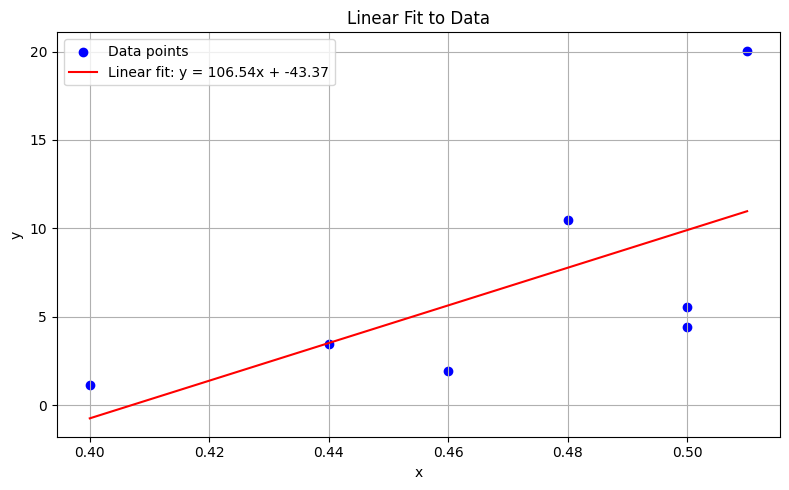

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
d = ['Exchange', 'ETTm1', 'Weather', 'Electricity', 'Traffic', 'EEG', 'ECG']
x = [0.40,  0.44,  0.46, 0.48, 0.50, 0.50, 0.51]
y = [1.16, 3.43, 1.92, 10.46, 4.40, 5.54, 20.05]

# Fit a degree 1 polynomial (line)
m, n = np.polyfit(x, y, 1)

print(f"m = {m}")
print(f"n = {n}")

x_line = np.linspace(min(x), max(x), 100)
y_line = m * x_line + n

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x_line, y_line, color='red', label=f'Linear fit: y = {m:.2f}x + {n:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Fit to Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



m = 29.445454545454503
n = -7.993545454545433


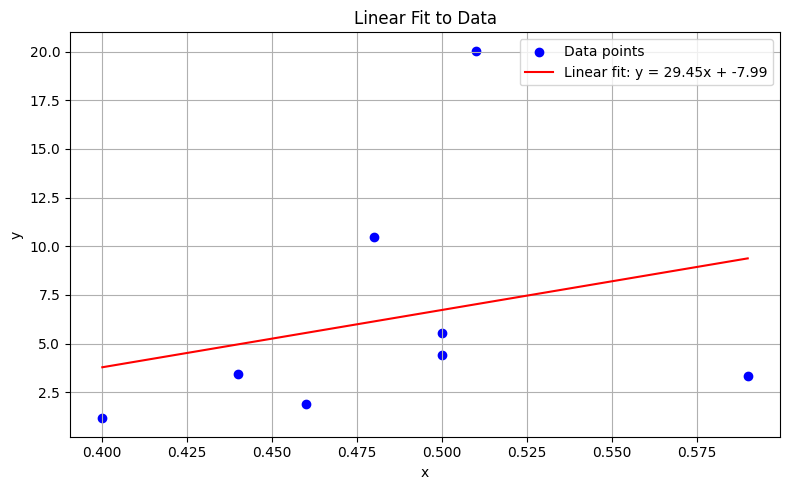

In [7]:
import numpy as np
import matplotlib.pyplot as plt

x = [0.40,  0.44,  0.46, 0.48, 0.50, 0.50, 0.51, 0.59]
y = [1.16, 3.43, 1.92, 10.46, 4.40, 5.54, 20.05, 3.34]

# Fit a degree 1 polynomial (line)
m, n = np.polyfit(x, y, 1)

print(f"m = {m}")
print(f"n = {n}")

x_line = np.linspace(min(x), max(x), 100)
y_line = m * x_line + n

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x_line, y_line, color='red', label=f'Linear fit: y = {m:.2f}x + {n:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Fit to Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

